In [1]:
from gd_analytic import *

# Linear algebra and numerical operations
import numpy as np
import pandas as pd
import autograd.numpy as np
from autograd import grad
from functools import partial

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
from prettytable import PrettyTable

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

# Random number generation
from random import random, seed

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def TestFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0
    return x**2 + y**2 + 2*x*y + random_noise

def FrankeFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + random_noise

def MSE(y_model, y_data):
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    y_model = y_model.reshape(-1, 1)
    return np.sum((y_data - y_model)**2)/n

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)
    
	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))
    
	for i in range(1, n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)
	return X

def generate_data(noise=True, step_size=0.05, FrankesFunction=True):
    # Arrange x and y
    x = np.arange(0, 1, step_size)
    y = np.arange(0, 1, step_size)
    # Create meshgrid of x and y
    X, Y = np.meshgrid(x, y)
    
    if FrankesFunction:
        # Calculate the values for Franke function
        z = FrankeFunction(X, Y, noise=noise).flatten()
    else:
        z = TestFunction(X, Y, noise=noise).flatten()

    # Flatten x and y for plotting
    x = X.flatten()
    y = Y.flatten()
    return x, y, z

def mse_and_r2_sk(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    return mse, r2

In [3]:
def train_test_error(X_train, X_test, z_train, z_test, model):
    model.fit(X_train, z_train, X_test, z_test)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_error = MSE(train_pred, z_train)
    test_error = MSE(test_pred, z_test)
    return train_error, test_error

# Test Function

In [4]:
n = 100
x = 2 * np.random.rand(n,1)
y = 4 + 3*x + 2*x**2 #+ 0.5 * np.random.randn(n,1)  # We chose a noise level of 0.5, because we want to show the lack of convergence in the Ridge regression case
                                                    # without adequate fine tuning
                                                    # the professor suggested me to remove the noise

# Design matrix
X = np.c_[np.ones((n,1)), x, x**2] # np.c_ = it translates slice objects to concatenation along the second axis (columns)

# Hessian matrix obtained from the OLS betas equation (second derivative)
H = (2.0/n)* X.T @ X

# Eigenvalues
# They give information about how sensitive the model is to changes in the parameters
EigValues, EigVectors = np.linalg.eig(H) 
print(f'Eigenvalues: {EigValues}')
print('-'*48)

# -------------------------------------------------- OLS beta --------------------------------------------------
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ y
print(f'OLS Betas: {beta_ols}')
print('-'*48)

# ------------------------------------------------- Ridge beta -------------------------------------------------
nlambdas = 40
lambdas = np.logspace(-10, 10, nlambdas)    # This generates nlambdas (40 in this case) evenly spaced,
                                            # starting from a minimum point of 10^(-10) and with a maximum point of 10^10

n_features = X.shape[1]                  # Number of features (columns) in the design matrix

# Identity matrix based on the number of features
I = np.eye(n_features, n_features)       # Identity matrix should match the number of features

# We create a dictionary, because the GridSearchCV expects a dictionary as its grid parameter
grid_parameter = {'alpha': lambdas} # alpha corresponds to lambda in Ridge for scikit-learn

ridge_model = Ridge(fit_intercept=False)

# Let's apply both the Grid Search and the Cross-Validation (cv=5 --> k = 5)
grid_search_cv = GridSearchCV(ridge_model, grid_parameter, cv=5, scoring='neg_mean_squared_error')  # VERY IMPORTANT:
                                                                                                    # We specified the parameter scoring='neg_mean_squared_error',
                                                                                                    # because GridSearchCV tries to maximize the score by default.
                                                                                                    # However, MSE is a minimization metric --> the lower the MSE, the better the model.
                                                                                                    # By considering the negative MSE values, GridSearchCV will be able to actually identify the best MSE.
# We fit grid_search_cv to out training data
grid_search_cv.fit(X, y)

# Finally, we are able to extrapolate the best lambda
best_lambda = grid_search_cv.best_params_['alpha']
print(f"Best lambda for Ridge regression: {best_lambda}")
print('-'*48)

best_lambda = 0.001 # the professor suggested me this modification

beta_ridge = np.linalg.pinv(X.T @ X + best_lambda *I) @ X.T @ y # We calculate the betas manually by computing the inversion matrix (requested from the exercise)
                                                                # Remember that in real life using the .best_estimator attribute of GridSearchCV is more efficient 
print(f'Ridge Betas: {beta_ridge}')
print('-'*48)

# ----------------------------------------- Gradient Descent Procedure -----------------------------------------
beta_ols_gd = np.random.randn(3,1)
eta = 1.0/np.max(EigValues)

Niterations = 1000

for iter in range(Niterations):
    gradient = (2.0/n) * X.T @ (X @ beta_ols_gd - y)
    beta_ols_gd -= eta*gradient

# We print the final beta values after running gradient descent
print(f'Gradient Descent OLS Betas: {beta_ols_gd}')
print('-'*48)

# 2) RIDGE BETA USING GRADIENT DESCENT
beta_ridge_gd = np.random.randn(3,1)

eta = 1.0/np.max(EigValues)

Niterations = 1000

for iter in range(Niterations):
    gradient_ridge = (2.0 / n) * X.T @ (X @ beta_ridge_gd - y) + 2 * best_lambda * beta_ridge_gd
    beta_ridge_gd -= eta*gradient_ridge

print(f'Gradient Descent Ridge Betas: {beta_ridge_gd}')

Eigenvalues: [10.61238205  0.7713061   0.03205576]
------------------------------------------------
OLS Betas: [[4.]
 [3.]
 [2.]]
------------------------------------------------
Best lambda for Ridge regression: 1e-10
------------------------------------------------
Ridge Betas: [[4.0000293 ]
 [2.99972818]
 [2.0001498 ]]
------------------------------------------------
Gradient Descent OLS Betas: [[4.04130944]
 [2.88985331]
 [2.05144232]]
------------------------------------------------
Gradient Descent Ridge Betas: [[4.00414029]
 [2.96963632]
 [2.01645804]]


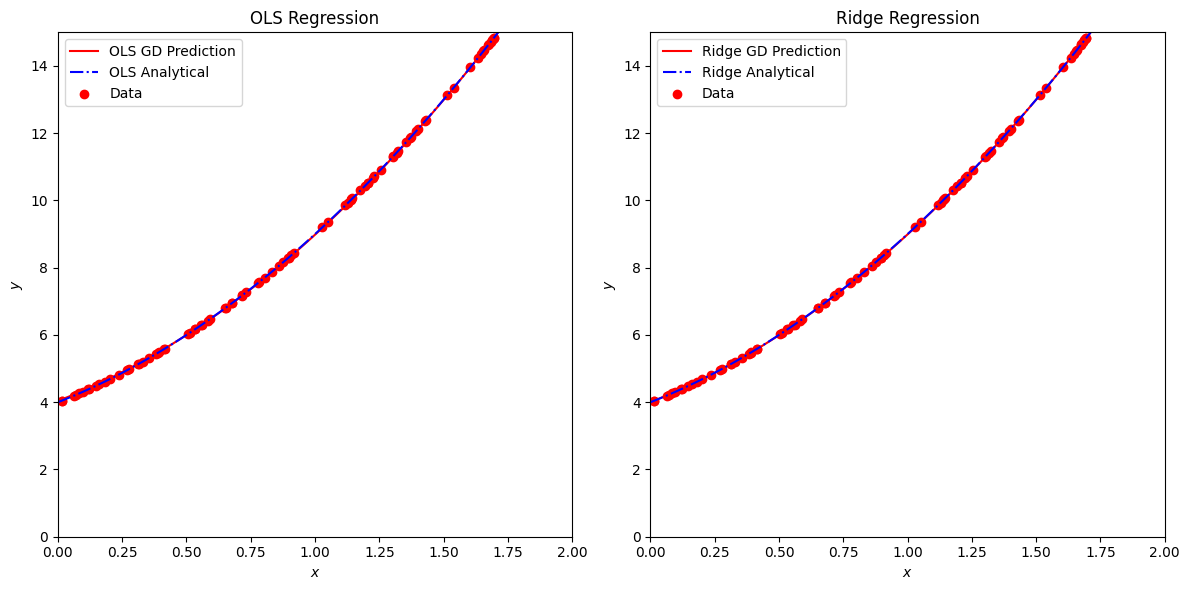

In [5]:
# Define a new range of x values for plotting the regression lines
x_range = np.linspace(0, 2, 100)  # 100 points between 0 and 2

# OLS Predictions
y_ols_gd_pred = beta_ols_gd[0] + beta_ols_gd[1] * x_range + beta_ols_gd[2] * x_range**2
y_ols_pred = beta_ols[0] + beta_ols[1] * x_range + beta_ols[2] * x_range**2

# Ridge Predictions
y_ridge_gd_pred = beta_ridge_gd[0] + beta_ridge_gd[1] * x_range + beta_ridge_gd[2] * x_range**2
y_ridge_pred = beta_ridge[0] + beta_ridge[1] * x_range + beta_ridge[2] * x_range**2

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# --------------------------------- OLS Plot ---------------------------------
axs[0].plot(x_range, y_ols_gd_pred, "r-", label="OLS GD Prediction")  # OLS Gradient Descent
axs[0].plot(x_range, y_ols_pred, "b-.", label="OLS Analytical")       # OLS Analytical
axs[0].scatter(x, y, color='red', label='Data')                       # Data points
axs[0].set_xlim([0, 2])
axs[0].set_ylim([0, 15])
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$y$')
axs[0].set_title(r'OLS Regression')
axs[0].legend()

# --------------------------------- Ridge Plot --------------------------------
axs[1].plot(x_range, y_ridge_gd_pred, "r-", label="Ridge GD Prediction")  # Ridge Gradient Descent
axs[1].plot(x_range, y_ridge_pred, "b-.", label="Ridge Analytical")       # Ridge Analytical
axs[1].scatter(x, y, color='red', label='Data')                           # Data points
axs[1].set_xlim([0, 2])
axs[1].set_ylim([0, 15])
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$y$')
axs[1].set_title(r'Ridge Regression')
axs[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Franke Function

In [6]:
np.random.seed(2024)
x, y, z = generate_data()
degree = 5
X = create_X(x, y, degree)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

### Gradient Descend

In [7]:
# Plain Gradient Descent with fix learning rate
gamma = 0.01

# ---------------------- OLS ----------------------
model_OLS = GradientDescend(momentum = False, learning_rate = gamma, max_epochs=1000)
train_error_OLS, test_error_OLS = train_test_error(X_train, X_test, z_train, z_test, model_OLS)

# ---------------------- Ridge ----------------------
model_Ridge = GradientDescend(momentum = False, learning_rate = gamma, Ridge=True, max_epochs=1000)
train_error_Ridge, test_error_Ridge = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
field_names = ["", "Train Error", "Test Error"]
result_table.field_names = field_names
result_table.add_row(["OLS", train_error_OLS, test_error_OLS])
result_table.add_row(["Ridge", train_error_Ridge, test_error_Ridge])
print(result_table)

+-------+--------------------+--------------------+
|       |    Train Error     |     Test Error     |
+-------+--------------------+--------------------+
|  OLS  | 2.1946310497461763 | 1.9364687627722859 |
| Ridge | 1.356539809339165  | 1.4683055224399353 |
+-------+--------------------+--------------------+


+---------------+---------------------+---------------------+
|               |         OLS         |        Ridge        |
+---------------+---------------------+---------------------+
| Optimal Gamma | 0.32499999999999996 |         0.01        |
|   Test error  |  0.5590795763769962 | 0.42619502293042577 |
+---------------+---------------------+---------------------+


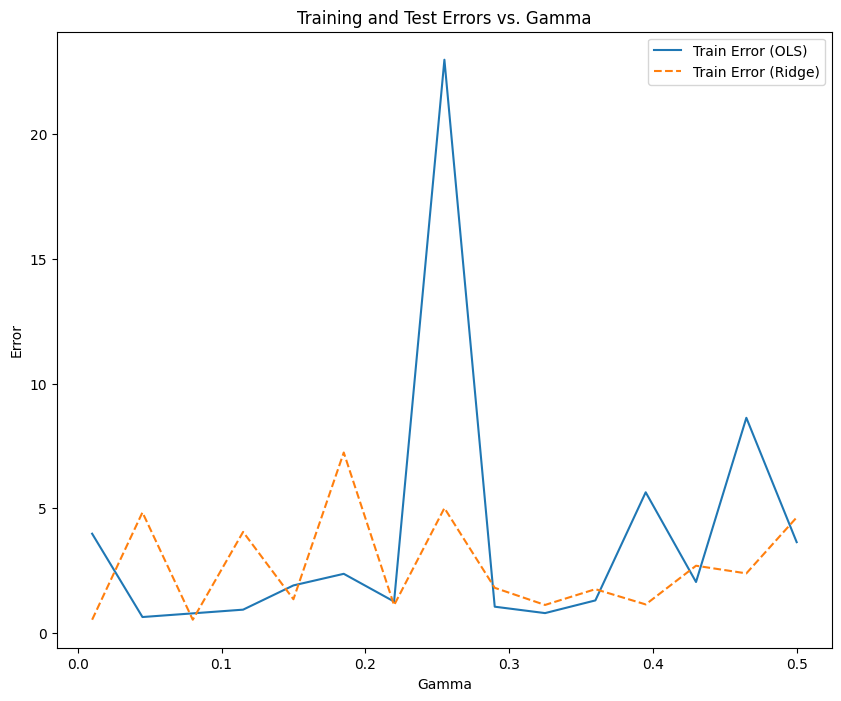

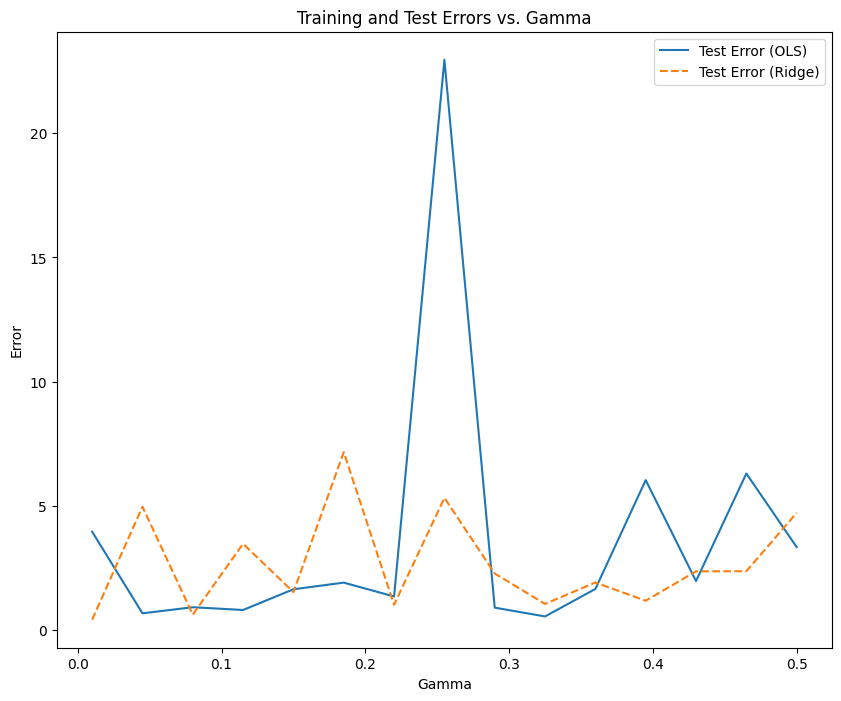

In [8]:
np.random.seed(2024)
gamma = np.linspace(0.01, 0.5, 15)

train_errors = np.zeros([len(gamma), 2])
test_errors = np.zeros([len(gamma), 2])

for g in range(len(gamma)):
    # ---------------------- OLS ----------------------
    model_OLS = GradientDescend(momentum = False, learning_rate = gamma[g], max_epochs=1000)
    train_errors[g, 0], test_errors[g, 0] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # ---------------------- Ridge ----------------------
    model_Ridge = GradientDescend(momentum = False, learning_rate = gamma[g], max_epochs=1000, Ridge=True)
    train_errors[g, 1], test_errors[g, 1] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

optimal_index = [np.argmin(test_errors[:, 0]), np.argmin(test_errors[:, 1])]
optimal_gamma = [gamma[optimal_index[0]], gamma[optimal_index[1]]]
optimal_test_error = [test_errors[:, 0][optimal_index[0]], test_errors[:, 1][optimal_index[1]]]

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
field_names = ["", "OLS", "Ridge"]
result_table.field_names = field_names
result_table.add_row(["Optimal Gamma"] + optimal_gamma)
result_table.add_row(["Test error"] + optimal_test_error)
print(result_table)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(gamma, train_errors[:, 0], label="Train Error (OLS)", linestyle='-')
plt.plot(gamma, train_errors[:, 1], label="Train Error (Ridge)", linestyle='--')
plt.title("Training and Test Errors vs. Gamma")
plt.xlabel("Gamma")
plt.ylabel("Error")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(gamma, test_errors[:, 0], label="Test Error (OLS)", linestyle='-')
plt.plot(gamma, test_errors[:, 1], label="Test Error (Ridge)", linestyle='--')
plt.title("Training and Test Errors vs. Gamma")
plt.xlabel("Gamma")
plt.ylabel("Error")
plt.legend()
# plt.savefig("/Users/elisaottoboni/Desktop/ML/Images/Test_OLS_vs_Ridge.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Gradient Descend with momentum

+---------------+--------------------+---------------------+
|               |        OLS         |        Ridge        |
+---------------+--------------------+---------------------+
| Optimal Gamma |       0.185        |         0.5         |
| Optimal Delta | 0.8499999999999999 |         0.6         |
|   Test error  | 0.1800705074965288 | 0.08492879639450164 |
+---------------+--------------------+---------------------+


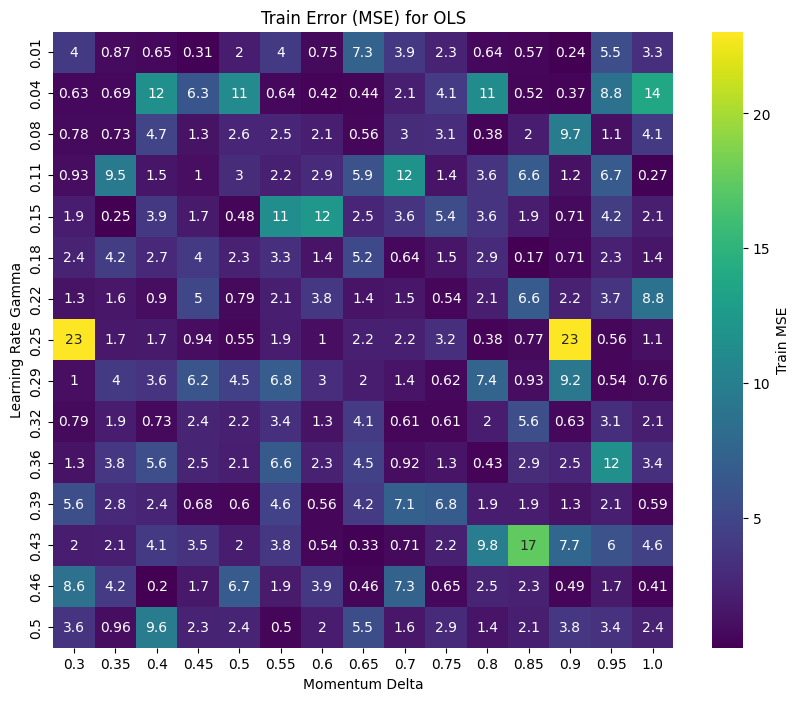

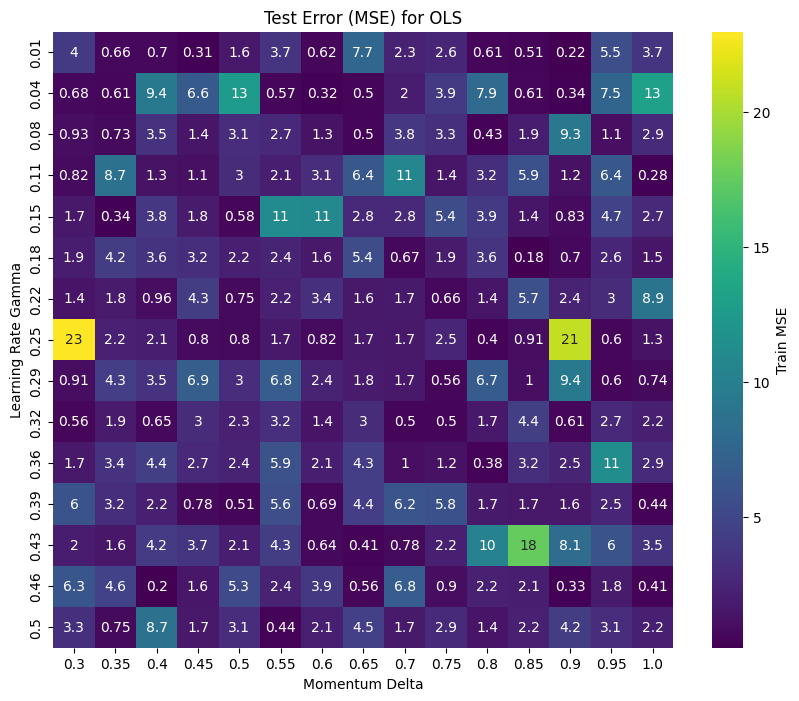

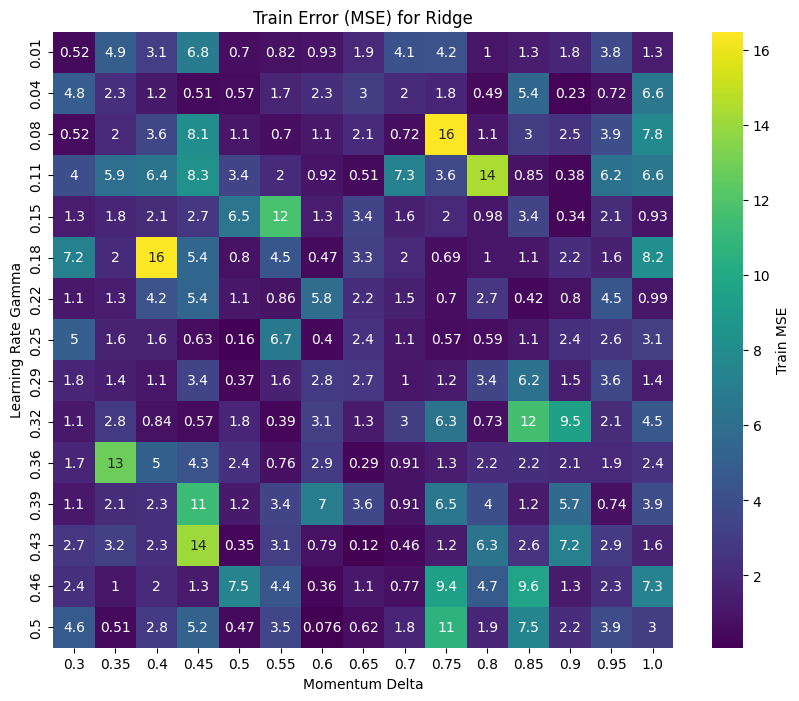

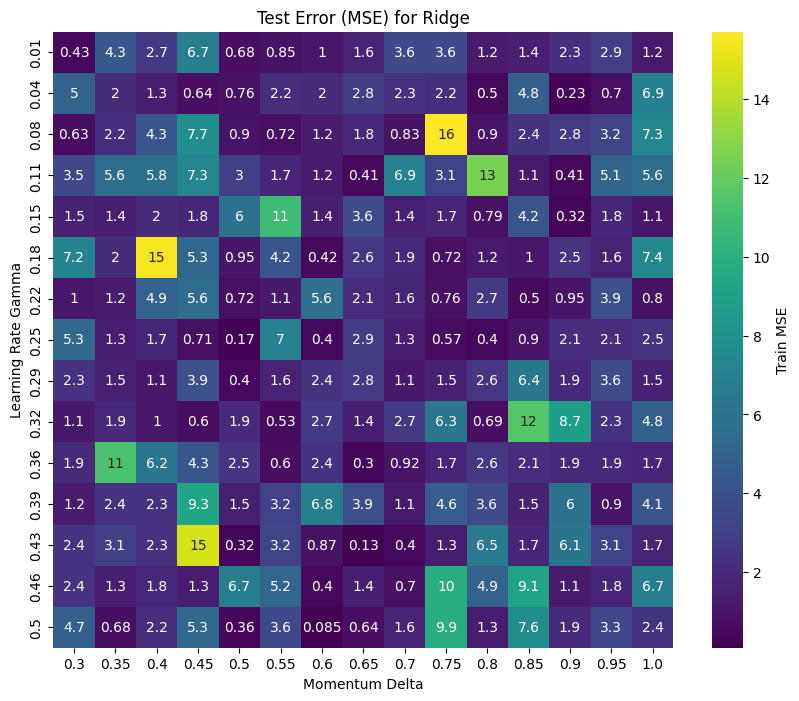

In [9]:
# Momentum
np.random.seed(2024)
gamma = np.linspace(0.01, 0.5, 15)
delta = np.linspace(0.3, 1, 15)

train_errors_mom_OLS = np.zeros((len(gamma), len(delta)))
test_errors_mom_OLS = np.zeros((len(gamma), len(delta)))

train_errors_mom_Ridge = np.zeros((len(gamma), len(delta)))
test_errors_mom_Ridge = np.zeros((len(gamma), len(delta)))

for d in range(len(delta)):
    for g in range(len(gamma)):
        # ---------------------- OLS ----------------------
        model_OLS = GradientDescend(learning_rate=gamma[g], delta_momentum=delta[d])
        train_errors_mom_OLS[g, d], test_errors_mom_OLS[g, d] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
        
        # ---------------------- Ridge ----------------------
        model_Ridge = GradientDescend(learning_rate=gamma[g], delta_momentum=delta[d], Ridge=True)
        train_errors_mom_Ridge[g, d], test_errors_mom_Ridge[g, d] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

min_test_error_idx_OLS = np.unravel_index(np.argmin(test_errors_mom_OLS), test_errors_mom_OLS.shape)
min_test_error_idx_Ridge = np.unravel_index(np.argmin(test_errors_mom_Ridge), test_errors_mom_Ridge.shape)
optimal_gamma = [gamma[min_test_error_idx_OLS[0]], gamma[min_test_error_idx_Ridge[0]]]
optimal_delta = [delta[min_test_error_idx_OLS[1]], delta[min_test_error_idx_Ridge[1]]]

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
field_names = ["", "OLS", "Ridge"]
result_table.field_names = field_names
result_table.add_row(["Optimal Gamma"] + optimal_gamma)
result_table.add_row(["Optimal Delta"] + optimal_delta)
result_table.add_row(["Test error", test_errors_mom_OLS[min_test_error_idx_OLS],  
                                    test_errors_mom_Ridge[min_test_error_idx_Ridge]])
print(result_table)

# ---------------------- Plot the results ----------------------
plot = {'Train Error (MSE) for OLS': train_errors_mom_OLS, 
        'Test Error (MSE) for OLS': test_errors_mom_OLS,
        'Train Error (MSE) for Ridge': train_errors_mom_Ridge,
        'Test Error (MSE) for Ridge': test_errors_mom_Ridge}

for p in plot.keys():
    plt.figure(figsize=(10, 8))

    # Heatmap
    sns.heatmap(plot[p], xticklabels=np.round(delta, 2), yticklabels=np.round(gamma, 2),
                cmap="viridis", annot=True, cbar_kws={'label': 'Train MSE'})
    plt.title(p)
    plt.xlabel("Momentum Delta")
    plt.ylabel("Learning Rate Gamma")
    # plt.savefig(f"/Users/elisaottoboni/Desktop/ML/Images/Heatmap_{p}.pdf", format='pdf', bbox_inches='tight')
    plt.show()

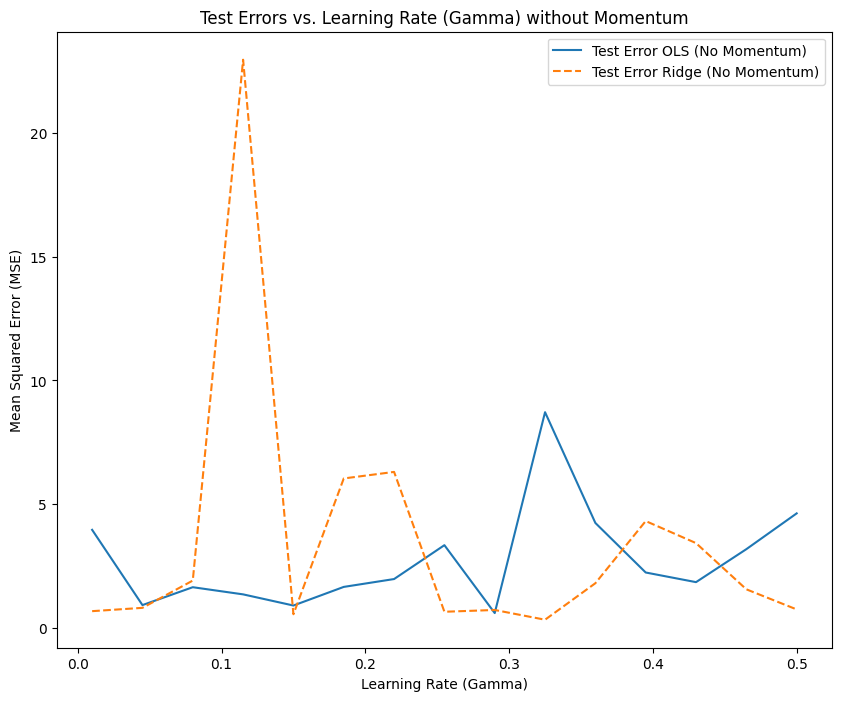

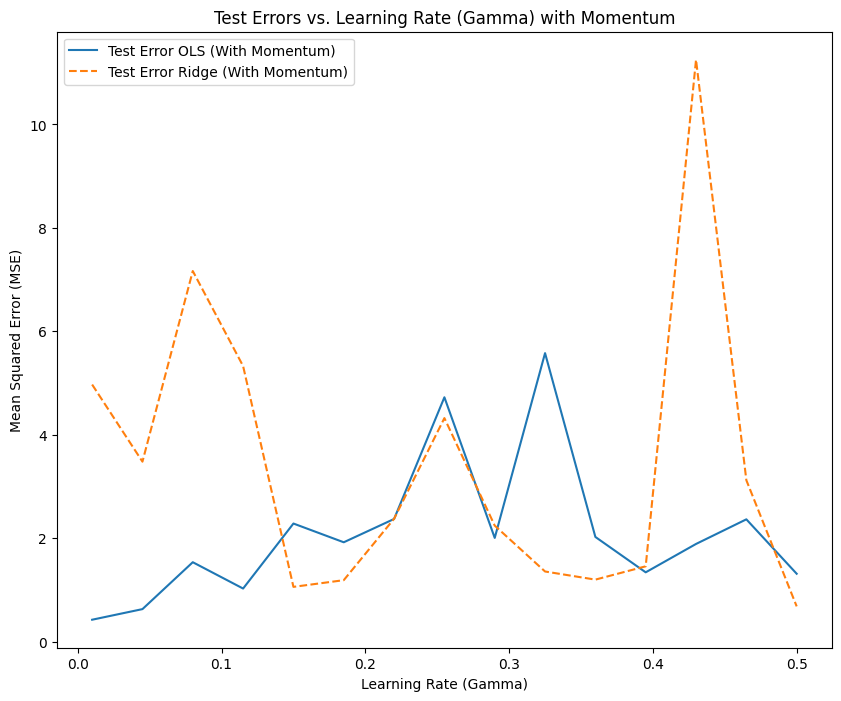

In [10]:
# Plain Gradient Descent with momentum and fix learning rate
np.random.seed(2024)
gamma = np.linspace(0.01, 0.5, 15)

train_errors = np.zeros((len(gamma), 2))
test_errors = np.zeros((len(gamma), 2))
train_errors_mom = np.zeros((len(gamma), 2))
test_errors_mom = np.zeros((len(gamma), 2))

for g in range(len(gamma)):
    # ---------------------- OLS ----------------------
    model_OLS = GradientDescend(momentum = False, learning_rate = gamma[g])
    train_errors[g, 0], test_errors[g, 0] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # Momentum
    model_m_OLS = GradientDescend(learning_rate=gamma[g], delta_momentum=optimal_delta[0])
    train_errors_mom[g, 0], test_errors_mom[g, 0] = train_test_error(X_train, X_test, z_train, z_test, model_m_OLS)
    
    # ---------------------- Ridge ----------------------
    model_Ridge = GradientDescend(momentum = False, learning_rate = gamma[g], Ridge=True)
    train_errors[g, 1], test_errors[g, 1] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)
    
    # Momentum
    model_m_Ridge = GradientDescend(learning_rate=gamma[g], delta_momentum=optimal_delta[1], Ridge=True)
    train_errors_mom[g, 1], test_errors_mom[g, 1] = train_test_error(X_train, X_test, z_train, z_test, model_m_Ridge)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(gamma, test_errors[:, 0], label="Test Error OLS (No Momentum)", linestyle='-')
plt.plot(gamma, test_errors[:, 1], label="Test Error Ridge (No Momentum)", linestyle='--')
plt.title("Test Errors vs. Learning Rate (Gamma) without Momentum")
plt.xlabel("Learning Rate (Gamma)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

# Momentum
plt.figure(figsize=(10, 8))
plt.plot(gamma, test_errors_mom[:, 0], label="Test Error OLS (With Momentum)", linestyle='-')
plt.plot(gamma, test_errors_mom[:, 1], label="Test Error Ridge (With Momentum)", linestyle='--')
plt.title("Test Errors vs. Learning Rate (Gamma) with Momentum")
plt.xlabel("Learning Rate (Gamma)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

### Stocastic Gradient Descend

+---------------+---------------------+---------------------+
|               |         OLS         |        Ridge        |
+---------------+---------------------+---------------------+
| Optimal Gamma | 0.25499999999999995 |         0.15        |
| Optimal Delta |         1.0         | 0.39999999999999997 |
|   Test error  | 0.19181381764174216 | 0.21237551537206362 |
+---------------+---------------------+---------------------+


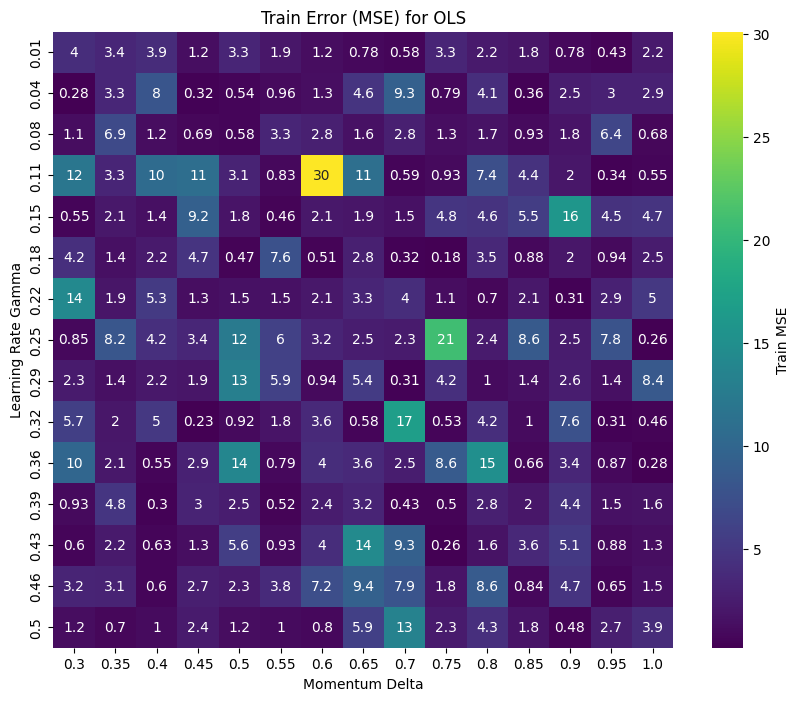

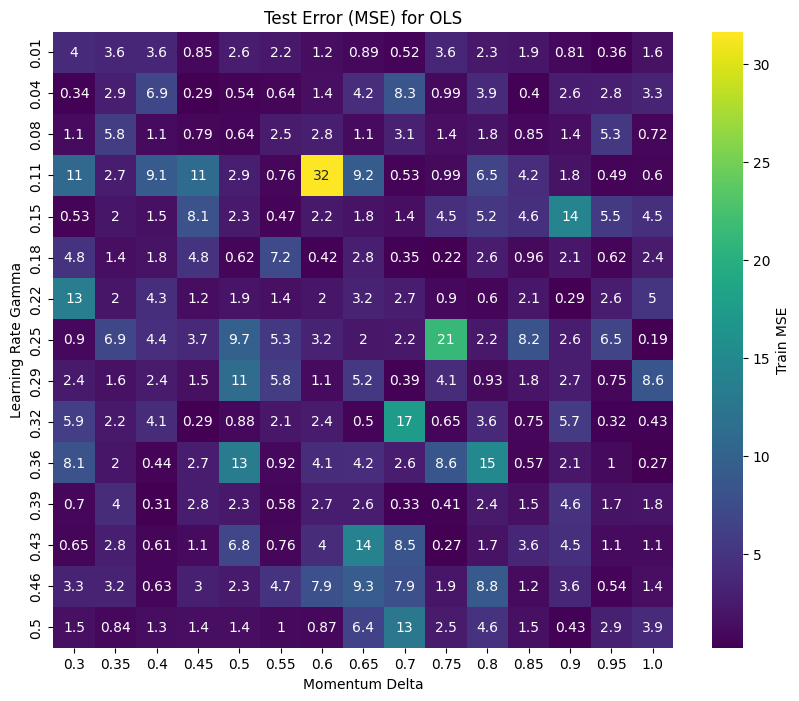

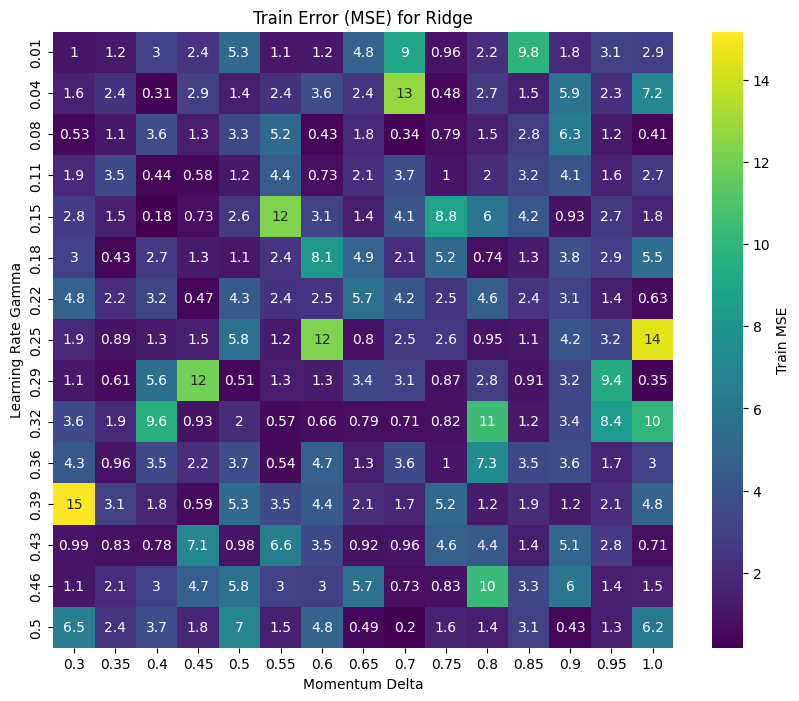

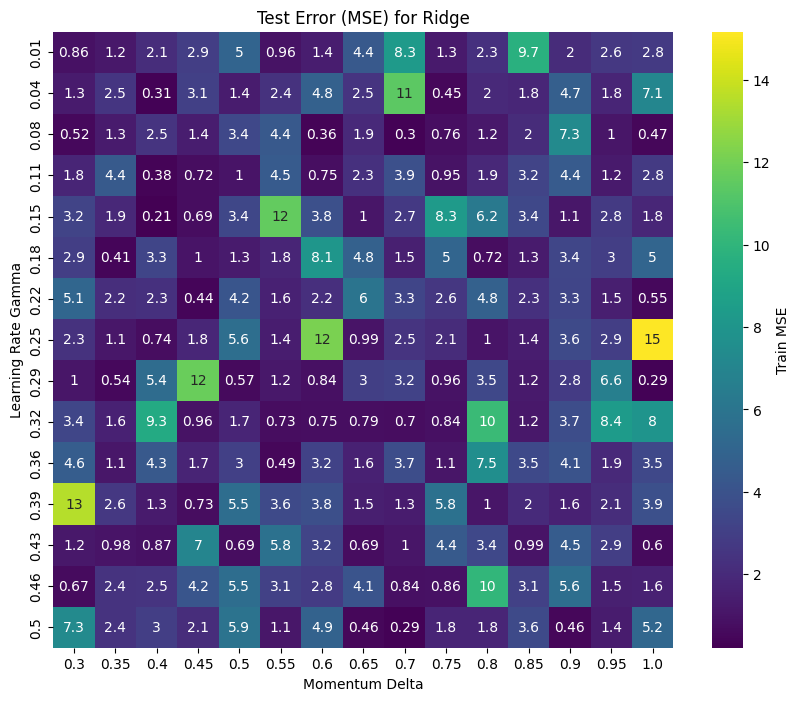

In [11]:
# Momentum
np.random.seed(2024)
gamma = np.linspace(0.01, 0.5, 15)
delta = np.linspace(0.3, 1, 15)

train_errors_mom_OLS = np.zeros((len(gamma), len(delta)))
test_errors_mom_OLS = np.zeros((len(gamma), len(delta)))

train_errors_mom_Ridge = np.zeros((len(gamma), len(delta)))
test_errors_mom_Ridge = np.zeros((len(gamma), len(delta)))

for d in range(len(delta)):
    for g in range(len(gamma)):
        # ---------------------- OLS ----------------------
        model_OLS = GradientDescend(optimizer="sgd", method="sgd", learning_rate=gamma[g], delta_momentum=delta[d])
        train_errors_mom_OLS[g, d], test_errors_mom_OLS[g, d] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
        
        # ---------------------- Ridge ----------------------
        model_Ridge = GradientDescend(optimizer="sgd", method="sgd", learning_rate=gamma[g], delta_momentum=delta[d], Ridge=True)
        train_errors_mom_Ridge[g, d], test_errors_mom_Ridge[g, d] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

min_test_error_idx_OLS = np.unravel_index(np.argmin(test_errors_mom_OLS), test_errors_mom_OLS.shape)
min_test_error_idx_Ridge = np.unravel_index(np.argmin(test_errors_mom_Ridge), test_errors_mom_Ridge.shape)
optimal_gamma = [gamma[min_test_error_idx_OLS[0]], gamma[min_test_error_idx_Ridge[0]]]
optimal_delta = [delta[min_test_error_idx_OLS[1]], delta[min_test_error_idx_Ridge[1]]]

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
field_names = ["", "OLS", "Ridge"]
result_table.field_names = field_names
result_table.add_row(["Optimal Gamma"] + optimal_gamma)
result_table.add_row(["Optimal Delta"] + optimal_delta)
result_table.add_row(["Test error", test_errors_mom_OLS[min_test_error_idx_OLS],  
                                    test_errors_mom_Ridge[min_test_error_idx_Ridge]])
print(result_table)

# ---------------------- Plot the results ----------------------
plot = {'Train Error (MSE) for OLS': train_errors_mom_OLS, 
        'Test Error (MSE) for OLS': test_errors_mom_OLS,
        'Train Error (MSE) for Ridge': train_errors_mom_Ridge,
        'Test Error (MSE) for Ridge': test_errors_mom_Ridge}

for p in plot.keys():
    plt.figure(figsize=(10, 8))

    # Heatmap
    sns.heatmap(plot[p], xticklabels=np.round(delta, 2), yticklabels=np.round(gamma, 2),
                cmap="viridis", annot=True, cbar_kws={'label': 'Train MSE'})
    plt.title(p)
    plt.xlabel("Momentum Delta")
    plt.ylabel("Learning Rate Gamma")
    plt.show()

+--------------------+-------------------+----------------------+
|                    |        OLS        |        Ridge         |
+--------------------+-------------------+----------------------+
| Optimal Batch Size |         70        |          40          |
|     Test error     | 30.30816568585875 | 0.022058374158033862 |
+--------------------+-------------------+----------------------+


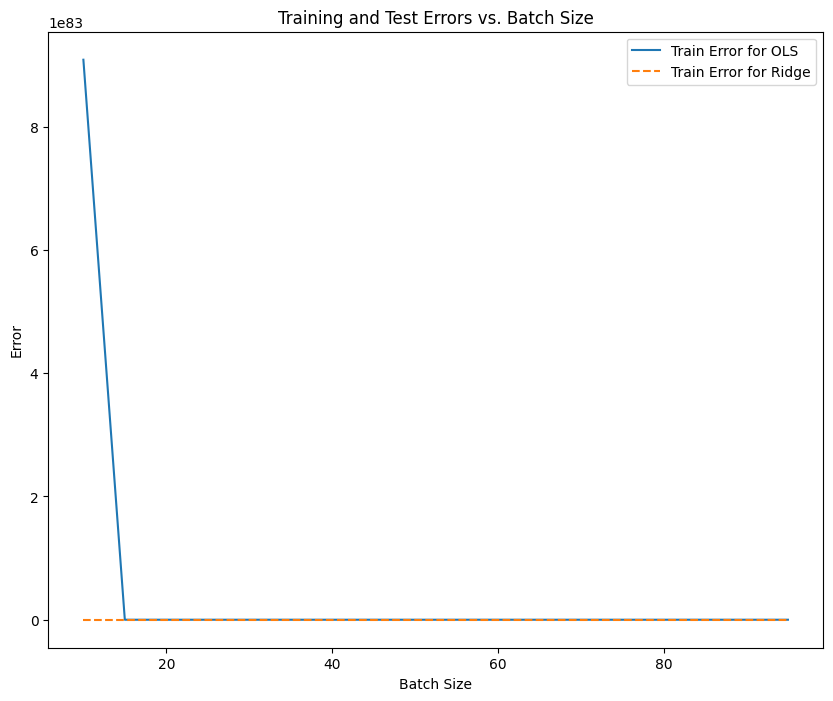

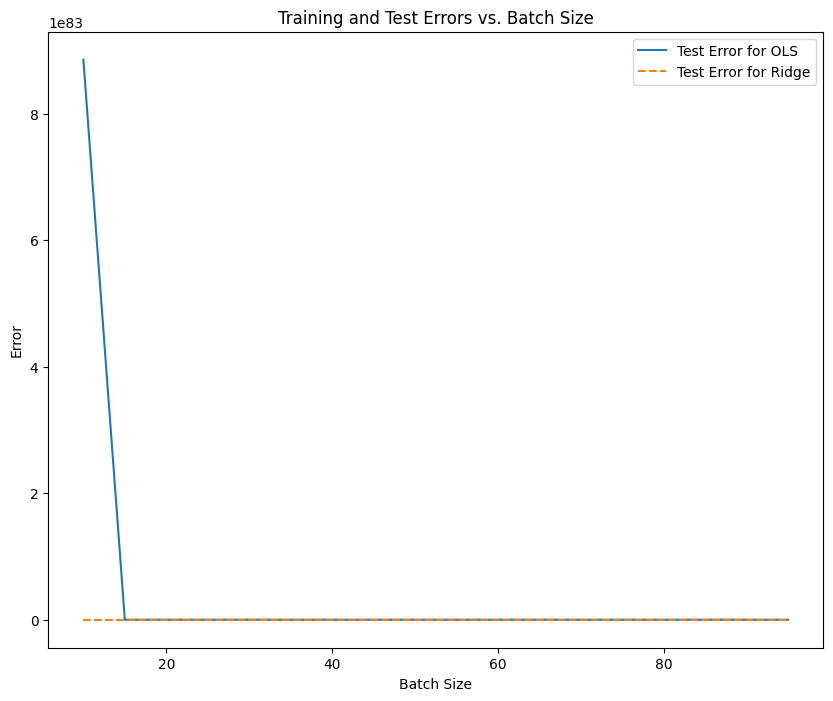

In [12]:
# Mini-batch with fixed eta, while gamma and delta we use the optimal value that we 
# computed with Stochastic Gradient Descent with momentum

np.random.seed(2024)

eta = 0.9
batch_size = np.arange(10, 100, 5)

train_errors = np.zeros((len(batch_size), 2))
test_errors = np.zeros((len(batch_size), 2))

for b in range(len(batch_size)):
    # ---------------------- OLS ----------------------
    model_OLS = GradientDescend(optimizer="sgd", method="sgd", learning_rate=optimal_gamma[0], 
                                delta_momentum=optimal_delta[0], learning_rate_decay_flag=True, 
                                learning_rate_decay=eta, batch_size=batch_size[b])
    train_errors[b, 0], test_errors[b, 0] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # ---------------------- Ridge ----------------------
    model_Ridge = GradientDescend(optimizer="sgd", method="sgd", Ridge=True, learning_rate=optimal_gamma[1], 
                                  delta_momentum=optimal_delta[1], learning_rate_decay_flag=True, 
                                  learning_rate_decay=eta, batch_size=batch_size[b])
    train_errors[b, 1], test_errors[b, 1] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge  )

optimal_index = [np.argmin(test_errors[:, 0]), np.argmin(test_errors[:, 1])]
optimal_batch_size = [batch_size[optimal_index[0]], batch_size[optimal_index[1]]]
optimal_test_error = [test_errors[:, 0][optimal_index[0]], test_errors[:, 1][optimal_index[1]]]

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
field_names = ["", "OLS", "Ridge"]
result_table.field_names = field_names
result_table.add_row(["Optimal Batch Size"] + optimal_batch_size)
result_table.add_row(["Test error"] + optimal_test_error)
print(result_table)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(batch_size, train_errors[:, 0], label="Train Error for OLS", linestyle='-')
plt.plot(batch_size, train_errors[:, 1], label="Train Error for Ridge", linestyle='--')
plt.title("Training and Test Errors vs. Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Error")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(batch_size, test_errors[:, 0], label="Test Error for OLS", linestyle='-')
plt.plot(batch_size, test_errors[:, 1], label="Test Error for Ridge", linestyle='--')
plt.title("Training and Test Errors vs. Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Error")
plt.legend()
plt.show()

+-------------+--------------------+----------------------+
|             |        OLS         |        Ridge         |
+-------------+--------------------+----------------------+
| Optimal Eta | 2.7928571428571427 |  1.342857142857143   |
|  Test error | 12.930377508254532 | 0.022058374158033862 |
+-------------+--------------------+----------------------+


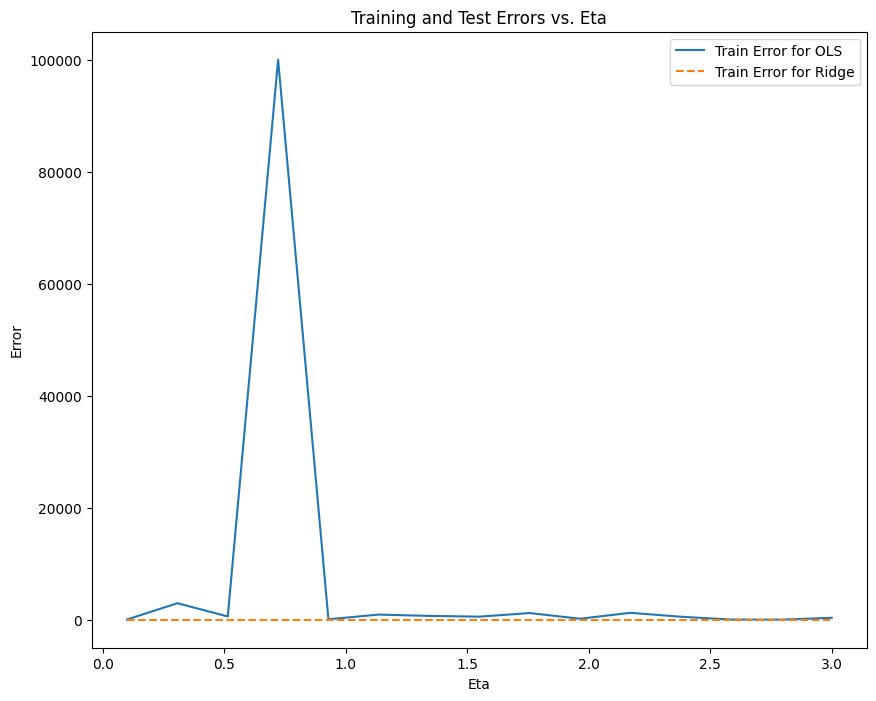

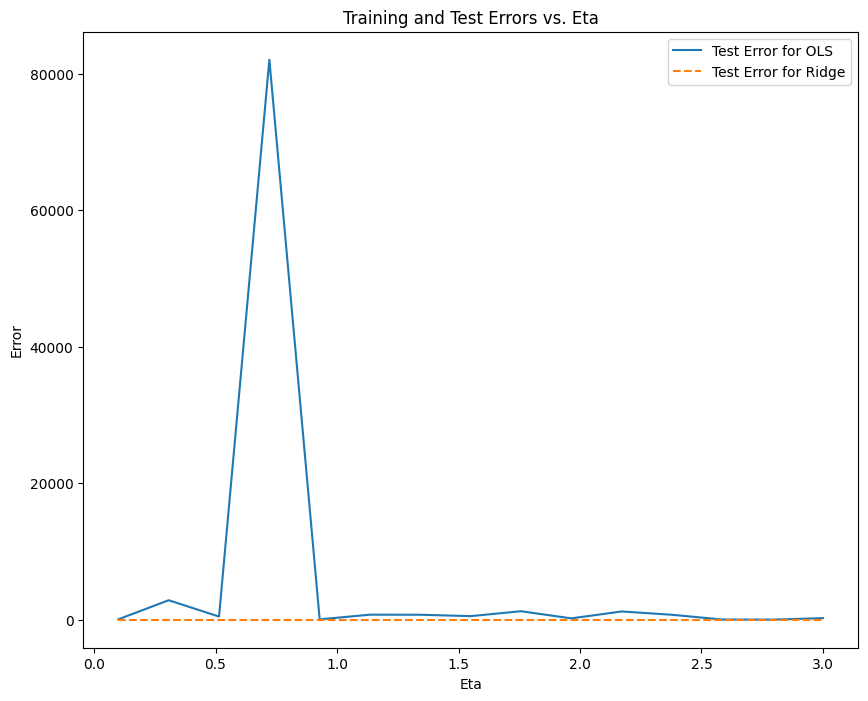

In [16]:
# Eta with fixed batch_size, while gamma and delta we use the optimal value that we 
# computed with Gradient Descent with momentum

np.random.seed(2024)

eta = np.linspace(0.1, 3, 15)

train_errors = np.zeros((len(eta), 2))
test_errors = np.zeros((len(eta), 2))

for e in range(len(eta)):
    # ---------------------- OLS ----------------------
    model_OLS = GradientDescend(optimizer="sgd", method="sgd", learning_rate=optimal_gamma[0], 
                                delta_momentum=optimal_delta[0], learning_rate_decay_flag=True, 
                                learning_rate_decay=eta[e], batch_size=optimal_batch_size[0])
    train_errors[e, 0], test_errors[e, 0] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # ---------------------- Ridge ----------------------
    model_Ridge = GradientDescend(optimizer="sgd", method="sgd", Ridge=True, learning_rate=optimal_gamma[1], 
                                  delta_momentum=optimal_delta[1], learning_rate_decay_flag=True, 
                                  learning_rate_decay=eta[e], batch_size=optimal_batch_size[1])
    train_errors[e, 1], test_errors[e, 1] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge  )

optimal_index = [np.argmin(test_errors[:, 0]), np.argmin(test_errors[:, 1])]
optimal_eta = [eta[optimal_index[0]], eta[optimal_index[1]]]
optimal_test_error = [test_errors[:, 0][optimal_index[0]], test_errors[:, 1][optimal_index[1]]]

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
field_names = ["", "OLS", "Ridge"]
result_table.field_names = field_names
result_table.add_row(["Optimal Eta"] + optimal_eta)
result_table.add_row(["Test error"] + optimal_test_error)
print(result_table)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(eta, train_errors[:, 0], label="Train Error for OLS", linestyle='-')
plt.plot(eta, train_errors[:, 1], label="Train Error for Ridge", linestyle='--')
plt.title("Training and Test Errors vs. Eta")
plt.xlabel("Eta")
plt.ylabel("Error")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(eta, test_errors[:, 0], label="Test Error for OLS", linestyle='-')
plt.plot(eta, test_errors[:, 1], label="Test Error for Ridge", linestyle='--')
plt.title("Training and Test Errors vs. Eta")
plt.xlabel("Eta")
plt.ylabel("Error")
plt.legend()
plt.show()

+--------------------+--------------------+---------------------+
|                    |        OLS         |        Ridge        |
+--------------------+--------------------+---------------------+
| Optimal Batch Size |         80         |          75         |
|    Optimal Eta     | 2.033333333333333  |  1.0666666666666667 |
|     Test error     | 0.1165254084468399 | 0.02107088767186879 |
+--------------------+--------------------+---------------------+


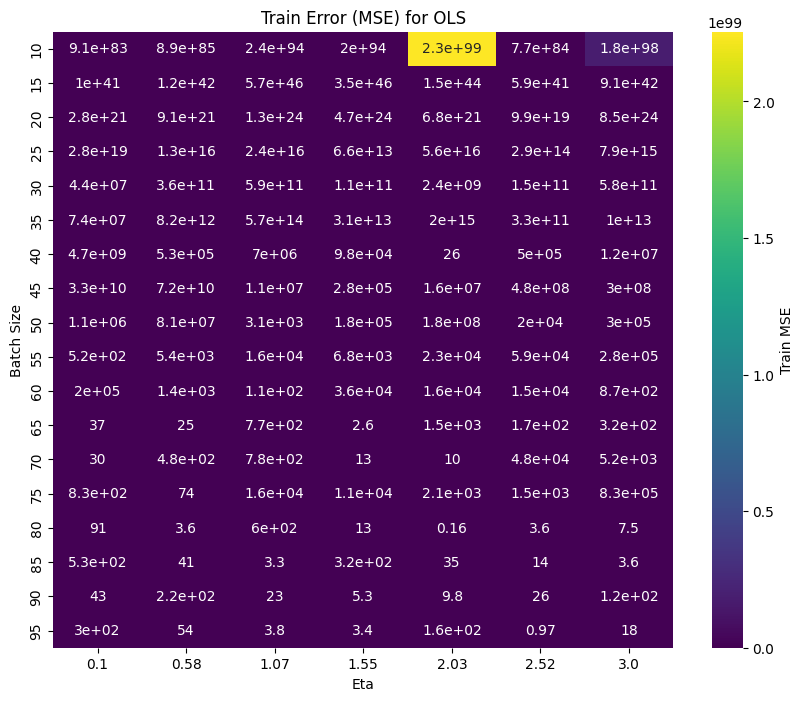

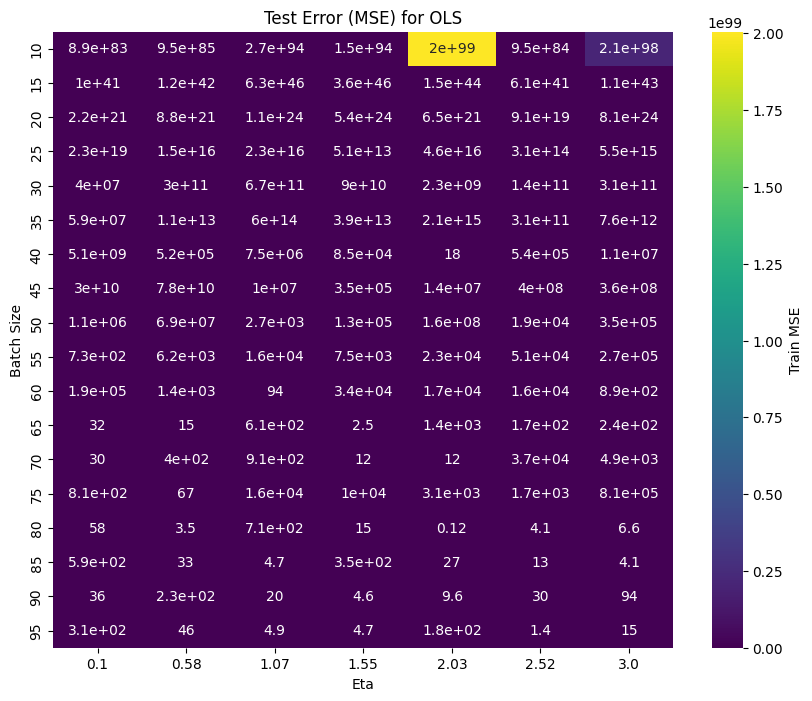

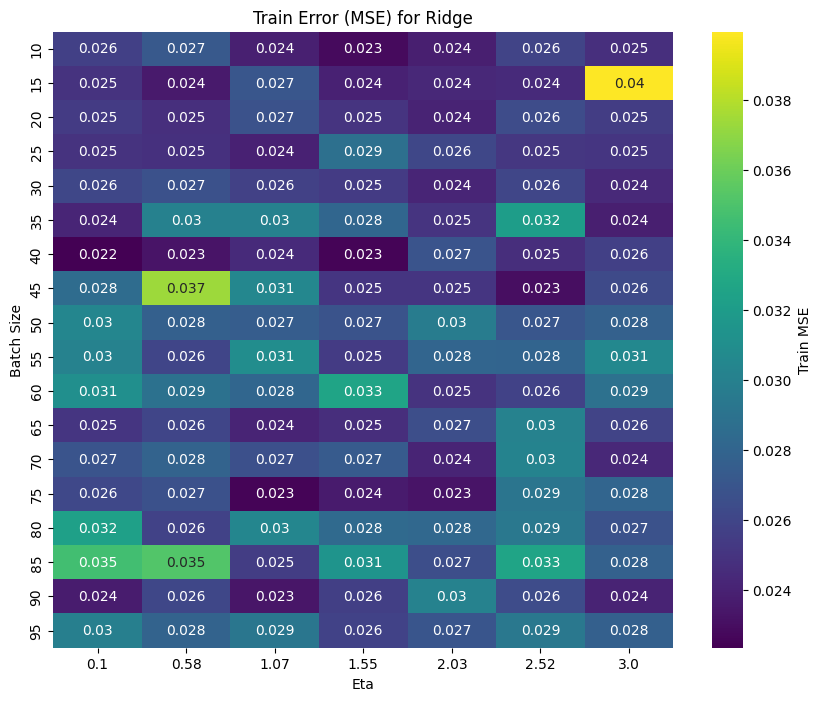

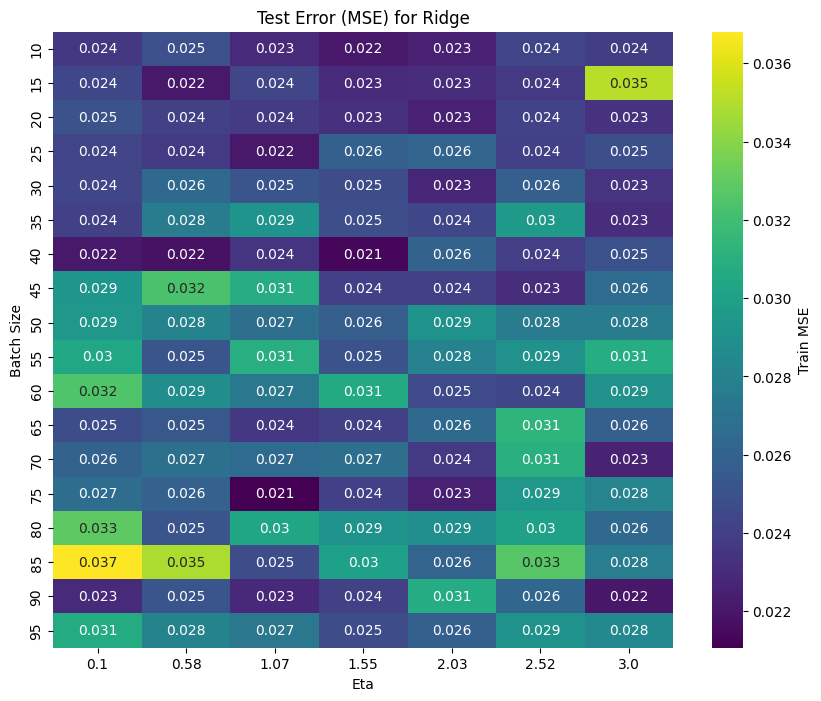

In [17]:
# Mini-batch and eta

np.random.seed(2024)

eta = np.linspace(0.1, 3, 7)
batch_size = np.arange(10, 100, 5)

train_errors_OLS = np.zeros((len(batch_size), len(eta)))
test_errors_OLS = np.zeros((len(batch_size), len(eta)))

train_errors_Ridge = np.zeros((len(batch_size), len(eta)))
test_errors_Ridge = np.zeros((len(batch_size), len(eta)))

for e in range(len(eta)):
    for b in range(len(batch_size)):
        # ---------------------- OLS ----------------------
        model_OLS = GradientDescend(optimizer="sgd", method="sgd", learning_rate=optimal_gamma[0], 
                                    delta_momentum=optimal_delta[0], learning_rate_decay_flag=True, 
                                    learning_rate_decay=eta[e], batch_size=batch_size[b])
        train_errors_OLS[b, e], test_errors_OLS[b, e] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
        
        # ---------------------- Ridge ----------------------
        model_Ridge = GradientDescend(optimizer="sgd", method="sgd", Ridge=True, learning_rate=optimal_gamma[1], 
                                      delta_momentum=optimal_delta[1], learning_rate_decay_flag=True, 
                                      learning_rate_decay=eta[e], batch_size=batch_size[b])
        train_errors_Ridge[b, e], test_errors_Ridge[b, e] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

min_test_error_idx_OLS = np.unravel_index(np.argmin(test_errors_OLS), test_errors_OLS.shape)
min_test_error_idx_Ridge = np.unravel_index(np.argmin(test_errors_Ridge), test_errors_Ridge.shape)
optimal_batch_size = [batch_size[min_test_error_idx_OLS[0]], batch_size[min_test_error_idx_Ridge[0]]]
optimal_eta = [eta[min_test_error_idx_OLS[1]], eta[min_test_error_idx_Ridge[1]]]

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
field_names = ["", "OLS", "Ridge"]
result_table.field_names = field_names
result_table.add_row(["Optimal Batch Size"] + optimal_batch_size)
result_table.add_row(["Optimal Eta"] + optimal_eta)
result_table.add_row(["Test error", test_errors_OLS[min_test_error_idx_OLS],  
                                    test_errors_Ridge[min_test_error_idx_Ridge]])
print(result_table)

# ---------------------- Plot the results ----------------------
plot = {'Train Error (MSE) for OLS': train_errors_OLS, 
        'Test Error (MSE) for OLS': test_errors_OLS,
        'Train Error (MSE) for Ridge': train_errors_Ridge,
        'Test Error (MSE) for Ridge': test_errors_Ridge}

for p in plot.keys():
    plt.figure(figsize=(10, 8))

    # Heatmap
    sns.heatmap(plot[p], xticklabels=np.round(eta, 2), yticklabels=np.round(batch_size, 2),
                cmap="viridis", annot=True, cbar_kws={'label': 'Train MSE'})
    plt.title(p)
    plt.xlabel("Eta")
    plt.ylabel("Batch Size")
    plt.show()

+--------------------+-------------------+----------------------+
|                    |        OLS        |        Ridge         |
+--------------------+-------------------+----------------------+
| Optimal Batch Size |         85        |          95          |
|   Optimal Epoch    |        300        |         800          |
|     Test error     | 0.076134291547206 | 0.027035413070736935 |
+--------------------+-------------------+----------------------+


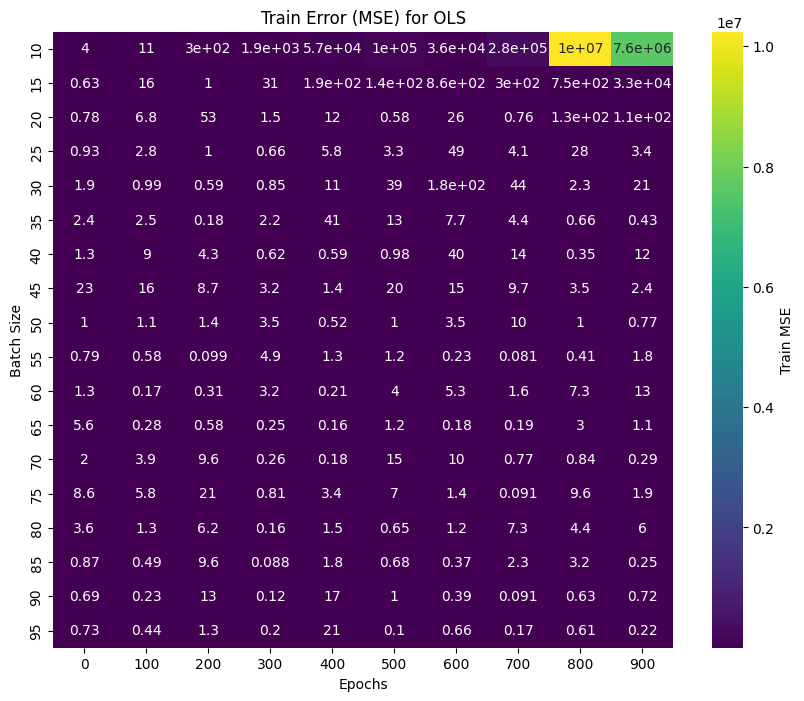

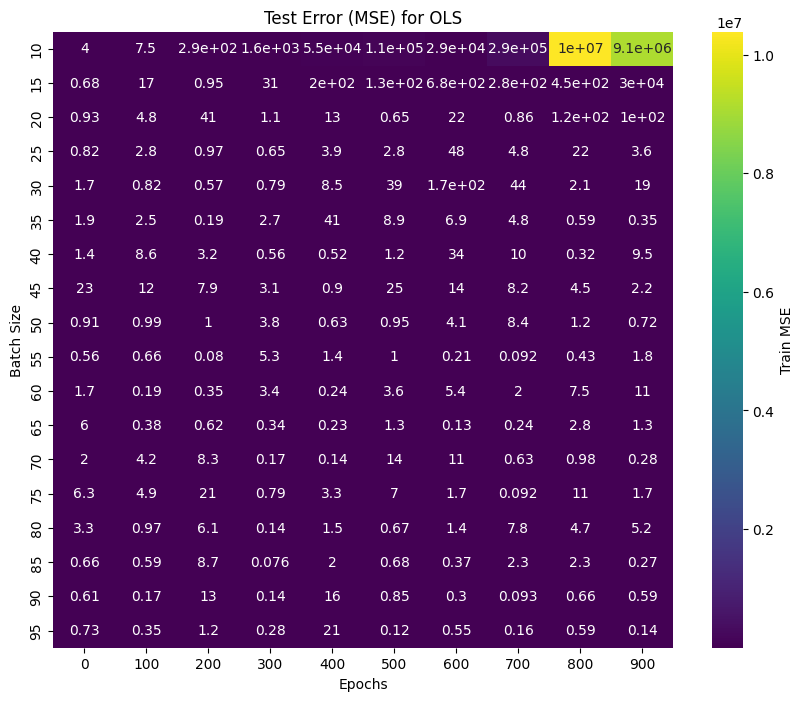

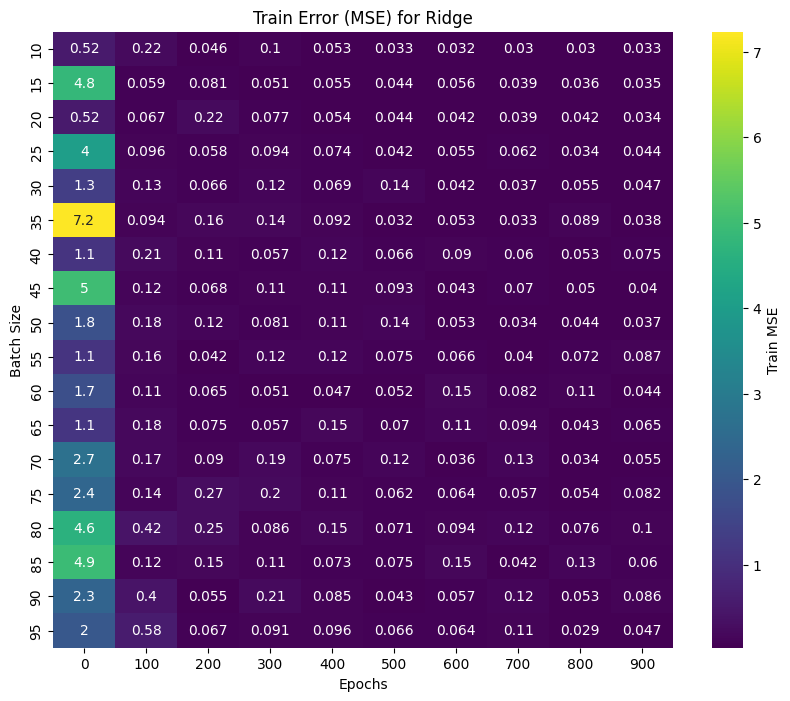

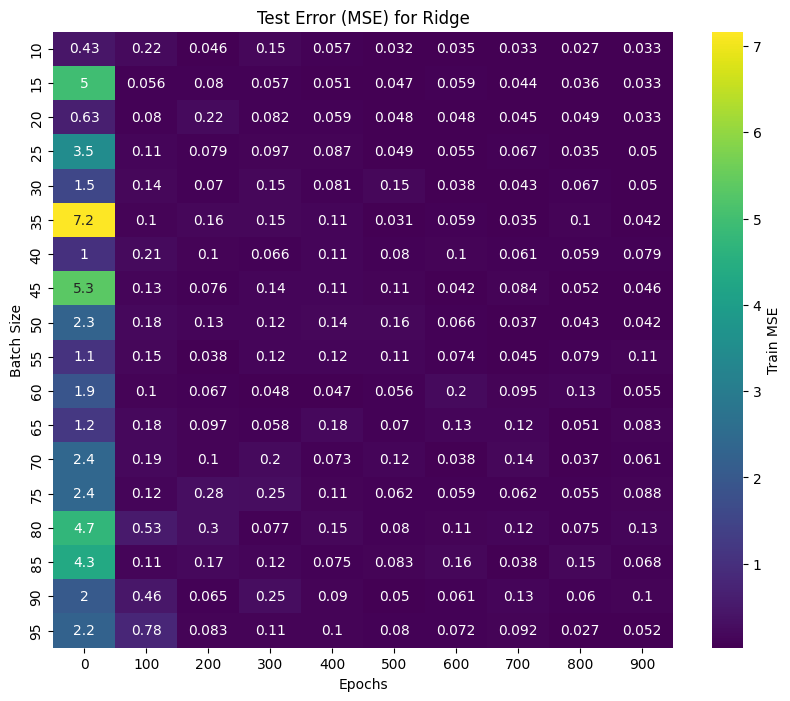

In [18]:
# Mini-batch and epoch

np.random.seed(2024)

batch_size = np.arange(10, 100, 5)
max_epochs = np.arange(0, 1000, 100)

train_errors_OLS = np.zeros((len(batch_size), len(max_epochs)))
test_errors_OLS = np.zeros((len(batch_size), len(max_epochs)))

train_errors_Ridge = np.zeros((len(batch_size), len(max_epochs)))
test_errors_Ridge = np.zeros((len(batch_size), len(max_epochs)))

for epoch in range(len(max_epochs)):
    for b in range(len(batch_size)):
        # ---------------------- OLS ----------------------
        model_OLS = GradientDescend(optimizer="sgd", method="sgd", learning_rate=optimal_gamma[0], 
                                    delta_momentum=optimal_delta[0], learning_rate_decay_flag=True, 
                                    learning_rate_decay=optimal_eta[0], batch_size=batch_size[b], 
                                    max_epochs=epoch)
        train_errors_OLS[b, epoch], test_errors_OLS[b, epoch] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
        
        # ---------------------- Ridge ----------------------
        model_Ridge = GradientDescend(optimizer="sgd", method="sgd", Ridge=True, 
                                      learning_rate=optimal_gamma[1], delta_momentum=optimal_delta[1], 
                                      learning_rate_decay_flag=True, learning_rate_decay=optimal_eta[1], 
                                      batch_size=batch_size[b], max_epochs=epoch)
        train_errors_Ridge[b, epoch], test_errors_Ridge[b, epoch] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

min_test_error_idx_OLS = np.unravel_index(np.argmin(test_errors_OLS), test_errors_OLS.shape)
min_test_error_idx_Ridge = np.unravel_index(np.argmin(test_errors_Ridge), test_errors_Ridge.shape)
optimal_batch_size = [batch_size[min_test_error_idx_OLS[0]], batch_size[min_test_error_idx_Ridge[0]]]
optimal_epoch = [max_epochs[min_test_error_idx_OLS[1]], max_epochs[min_test_error_idx_Ridge[1]]]

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
field_names = ["", "OLS", "Ridge"]
result_table.field_names = field_names
result_table.add_row(["Optimal Batch Size"] + optimal_batch_size)
result_table.add_row(["Optimal Epoch"] + optimal_epoch)
result_table.add_row(["Test error", test_errors_OLS[min_test_error_idx_OLS],  
                                    test_errors_Ridge[min_test_error_idx_Ridge]])
print(result_table)

# ---------------------- Plot the results ----------------------
plot = {'Train Error (MSE) for OLS': train_errors_OLS, 
        'Test Error (MSE) for OLS': test_errors_OLS,
        'Train Error (MSE) for Ridge': train_errors_Ridge,
        'Test Error (MSE) for Ridge': test_errors_Ridge}

for p in plot.keys():
    plt.figure(figsize=(10, 8))

    # Heatmap
    sns.heatmap(plot[p], xticklabels=np.round(max_epochs, 2), yticklabels=np.round(batch_size, 2),
                cmap="viridis", annot=True, cbar_kws={'label': 'Train MSE'})
    plt.title(p)
    plt.xlabel("Epochs")
    plt.ylabel("Batch Size")
    plt.show()

+-----------------------------+---------------------+---------------------+----------------------+----------------------+
|            Metodo           |    Train MSE OLS    |     Test MSE OLS    |   Train MSE Ridge    |    Test MSE Ridge    |
+-----------------------------+---------------------+---------------------+----------------------+----------------------+
|       Gradient Descent      | 0.34494887045105316 |  0.3001768822334374 |  0.297296167430536   |  0.2918839188232185  |
| Stochastic Gradient Descent | 0.23539366136541479 | 0.18131992549946688 | 0.026707251295107377 | 0.026242887536094828 |
|             ADAM            |   0.65859110000993  |  0.6051868697026406 |  0.6428731809959887  |  0.7908628376181912  |
+-----------------------------+---------------------+---------------------+----------------------+----------------------+


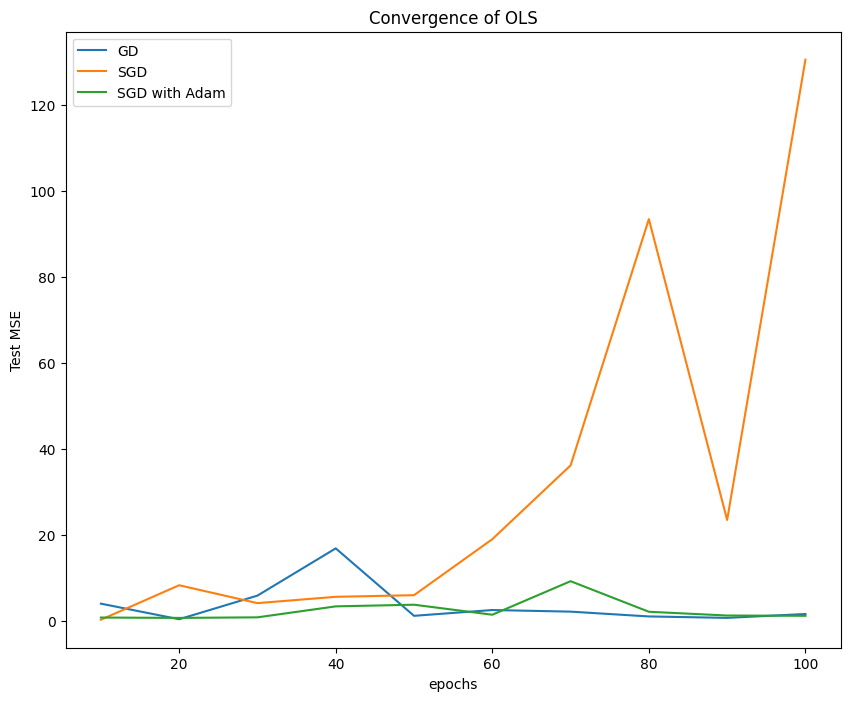

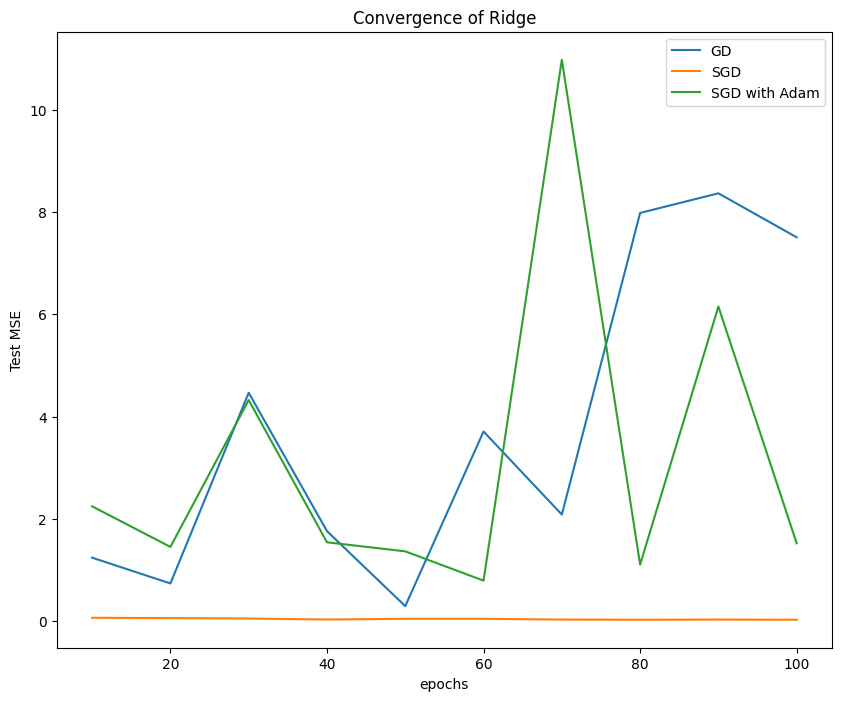

In [26]:
# Convergence
np.random.seed(2024)

epochs = np.arange(10, 101, 10)

gd = np.zeros((len(epochs), 4))
sgd = np.zeros((len(epochs), 4))
sgd_adam = np.zeros((len(epochs), 4))

for i in range(len(epochs)):
    # ---------------------- OLS ----------------------
    # Gradient Descend
    model_OLS = GradientDescend(optimizer="gd", method="gd", learning_rate=optimal_gamma[0], 
                                delta_momentum=optimal_delta[0], max_epochs=epochs[i])
    gd[i, 0], gd[i, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # Stocastic Gradient Descend
    model_OLS = GradientDescend(optimizer="sgd", method="sgd", learning_rate=optimal_gamma[0],
                                delta_momentum=optimal_delta[0], learning_rate_decay_flag=True, 
                                learning_rate_decay=optimal_eta[0], batch_size=optimal_batch_size[0], 
                                max_epochs=epochs[i])
    sgd[i, 0], sgd[i, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # ADAM
    model_OLS = GradientDescend(optimizer="sgd", method="ADAM", batch_size=optimal_batch_size[0], 
                                max_epochs=epochs[i])
    sgd_adam[i, 0], sgd_adam[i, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # ---------------------- Ridge ----------------------
    # Gradient Descend
    model_Ridge = GradientDescend(optimizer="gd", method="gd", Ridge=True, learning_rate=optimal_gamma[1], 
                                 delta_momentum=optimal_delta[1], max_epochs=epochs[i])
    gd[i, 2], gd[i, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)
    
    # Stocastic Gradient Descend
    model_Ridge = GradientDescend(optimizer="sgd", method="sgd", Ridge=True, learning_rate=optimal_gamma[1],
                                  delta_momentum=optimal_delta[1],learning_rate_decay_flag=True, 
                                  learning_rate_decay=optimal_eta[1], batch_size=optimal_batch_size[1],
                                  max_epochs=epochs[i])
    sgd[i, 2], sgd[i, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)
    
    # ADAM
    model_Ridge = GradientDescend(optimizer="sgd", method="ADAM", Ridge=True, batch_size=optimal_batch_size[1],
                                  max_epochs=epochs[i])
    sgd_adam[i, 2], sgd_adam[i, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)


min_train_error_idx_OLS_gd = np.argmin(gd[:, 0])
min_test_error_idx_OLS_gd = np.argmin(gd[:, 1])
min_train_error_idx_OLS_sgd = np.argmin(sgd[:, 0])
min_test_error_idx_OLS_sgd = np.argmin(sgd[:, 1])
min_train_error_idx_OLS_sgd_adam = np.argmin(sgd_adam[:, 0])
min_test_error_idx_OLS_sgd_adam = np.argmin(sgd_adam[:, 1])

min_train_error_idx_Ridge_gd = np.argmin(gd[:, 2])
min_test_error_idx_Ridge_gd = np.argmin(gd[:, 3])
min_train_error_idx_Ridge_sgd = np.argmin(sgd[:, 2])
min_test_error_idx_Ridge_sgd = np.argmin(sgd[:, 3])
min_train_error_idx_Ridge_sgd_adam = np.argmin(sgd_adam[:, 2])
min_test_error_idx_Ridge_sgd_adam = np.argmin(sgd_adam[:, 3])

optimal_gd = [
    gd[min_train_error_idx_OLS_gd, 0], gd[min_test_error_idx_OLS_gd, 1], 
    gd[min_train_error_idx_Ridge_gd, 2], gd[min_test_error_idx_Ridge_gd, 3]
]
optimal_sgd = [
    sgd[min_train_error_idx_OLS_sgd, 0], sgd[min_test_error_idx_OLS_sgd, 1], 
    sgd[min_train_error_idx_Ridge_sgd, 2], sgd[min_test_error_idx_Ridge_sgd, 3]
]
optimal_sgd_adam = [
    sgd_adam[min_train_error_idx_OLS_sgd_adam, 0], sgd_adam[min_test_error_idx_OLS_sgd_adam, 1], 
    sgd_adam[min_train_error_idx_Ridge_sgd_adam, 2], sgd_adam[min_test_error_idx_Ridge_sgd_adam, 3]
]

# ---------------------- Results ----------------------
result_table = PrettyTable()
result_table.field_names = ["Metodo", "Train MSE OLS", "Test MSE OLS", "Train MSE Ridge", "Test MSE Ridge"]
result_table.add_row(["Gradient Descent"] + optimal_gd)
result_table.add_row(["Stochastic Gradient Descent"] + optimal_sgd)
result_table.add_row(["ADAM"] + optimal_sgd_adam)
print(result_table)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(epochs, gd[:, 0], label="GD")
plt.plot(epochs, sgd[:, 0], label="SGD")
plt.plot(epochs, sgd_adam[:, 0], label="SGD with Adam")
plt.title("Convergence of OLS")
plt.xlabel("epochs")
plt.ylabel("Test MSE")
plt.legend()
plt.savefig(f"/Users/elisaottoboni/Desktop/ML/Images/Convergence_OLS.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(epochs, gd[:, 3], label="GD")
plt.plot(epochs, sgd[:, 3], label="SGD")
plt.plot(epochs, sgd_adam[:, 3], label="SGD with Adam")
plt.title("Convergence of Ridge")
plt.xlabel("epochs")
plt.ylabel("Test MSE")
plt.legend()
plt.savefig(f"/Users/elisaottoboni/Desktop/ML/Images/Convergence_Ridge.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Adagrad, RMSprop and Adam

In [27]:
# Variable Batch_size
np.random.seed(2024)

batch_size = np.arange(10, 100, 5)

errors_gd = np.zeros((len(batch_size), 4))
errors_gdm = np.zeros((len(batch_size), 4))
errors_sgd = np.zeros((len(batch_size), 4))
errors_sgdm = np.zeros((len(batch_size), 4))
errors_rms = np.zeros((len(batch_size), 4))
errors_adam = np.zeros((len(batch_size), 4))

for b in range(len(batch_size)):
    # ---------------------- OLS ----------------------
    # GD without momentum
    model_OLS = GradientDescend(momentum=False, method="Adagrad_GD", learning_rate=optimal_gamma[0], 
                                batch_size=batch_size[b])
    errors_gd[b, 0], errors_gd[b, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # GD with momentum
    model_OLS = GradientDescend(method="Adagrad_GD", learning_rate=optimal_gamma[0], 
                                delta_momentum=optimal_delta[0], batch_size=batch_size[b])
    errors_gdm[b, 0], errors_gdm[b, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # SGD without momentum
    model_OLS = GradientDescend(momentum=False, optimizer='sgd', method="Adagrad_GD", 
                                learning_rate=optimal_gamma[0], batch_size=batch_size[b])
    errors_sgd[b, 0], errors_sgd[b, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # SGD with momentum
    model_OLS = GradientDescend(optimizer='sgd', method="Adagrad_GD", learning_rate=optimal_gamma[0], 
                                delta_momentum=optimal_delta[0], batch_size=batch_size[b])
    errors_sgdm[b, 0], errors_sgdm[b, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # RMS with momentum
    model_OLS = GradientDescend(optimizer='sgd', method="RMSprop", batch_size=batch_size[b])
    errors_rms[b, 0], errors_rms[b, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # ADAM with momentum
    model_OLS = GradientDescend(optimizer='sgd', method="ADAM", batch_size=batch_size[b])
    errors_adam[b, 0], errors_adam[b, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)
    
    # ---------------------- Ridge ----------------------
    # GD without momentum
    model_Ridge = GradientDescend(momentum=False, method="Adagrad_GD", Ridge=True, learning_rate=optimal_gamma[1], batch_size=batch_size[b])
    errors_gd[b, 2], errors_gd[b, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)
    
    # GD with momentum
    model_Ridge = GradientDescend(method="Adagrad_GD", Ridge=True, learning_rate=optimal_gamma[1], delta_momentum=optimal_delta[1], batch_size=batch_size[b])
    errors_gdm[b, 2], errors_gdm[b, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)
    
    # SGD without momentum
    model_Ridge = GradientDescend(momentum=False, optimizer='sgd', method="Adagrad_GD", Ridge=True, learning_rate=optimal_gamma[1], batch_size=batch_size[b])
    errors_sgd[b, 2], errors_sgd[b, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)
    
    # SGD with momentum
    model_Ridge = GradientDescend(optimizer='sgd', method="Adagrad_GD", batch_size=batch_size[b])
    errors_sgdm[b, 2], errors_sgdm[b, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)
    
    # RMS with momentum
    model = GradientDescend(optimizer='sgd', method="RMSprop", Ridge=True, learning_rate=optimal_gamma[1], delta_momentum=optimal_delta[1], batch_size=batch_size[b])
    errors_rms[b, 2], errors_rms[b, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)
    
    # ADAM with momentum
    model_Ridge = GradientDescend(optimizer='sgd', method="ADAM", Ridge=True, batch_size=batch_size[b])
    errors_adam[b, 2], errors_adam[b, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

methods = {
    'gd': errors_gd,
    'gdm': errors_gdm,
    'sgd': errors_sgd,
    'sgdm': errors_sgdm,
    'rms': errors_rms,
    'adam': errors_adam
}

optimal_batch_size = np.zeros((len(methods), 2))
optimal_test_error = np.zeros((len(methods), 2))
for m, method in enumerate(methods.keys()):
    optimal_index = [np.argmin(methods[method][:, 1]), np.argmin(methods[method][:, 3])]
    optimal_batch_size[m] = batch_size[optimal_index[0]], batch_size[optimal_index[1]]
    optimal_test_error[m] = methods[method][:, 1][optimal_index[0]], methods[method][:, 3][optimal_index[1]]

# ---------------------- Print the results ----------------------
result_table = PrettyTable()
index = ["GD AdaGrad", "GD mom AdaGrad", "SGD AdaGrad", "SGD mom AdaGrad", "SGD mom RMSprop", "SGD mom Adam"]
field_names = ["", "OLS", "Test error OLS", "Ridge", "Test Error Ridge"]
result_table.field_names = field_names
for m in range(0, len(optimal_batch_size.ravel()), 2):
    result_table.add_row([f"Optimal Batch Size ({index[int(m/2)]})", optimal_batch_size.ravel()[m], optimal_test_error.ravel()[m], 
                            optimal_batch_size.ravel()[m + 1], optimal_test_error.ravel()[m + 1]])
print(result_table)

+--------------------------------------+------+---------------------+-------+---------------------+
|                                      | OLS  |    Test error OLS   | Ridge |   Test Error Ridge  |
+--------------------------------------+------+---------------------+-------+---------------------+
|   Optimal Batch Size (GD AdaGrad)    | 15.0 |  0.5280935828666985 |  45.0 |  0.4393831167088246 |
| Optimal Batch Size (GD mom AdaGrad)  | 85.0 | 0.31409800113032277 |  15.0 | 0.37369724613481636 |
|   Optimal Batch Size (SGD AdaGrad)   | 75.0 |  0.4715126973550012 |  15.0 | 0.31129516241210453 |
| Optimal Batch Size (SGD mom AdaGrad) | 25.0 |  0.5150458863386592 |  95.0 | 0.30689288861860625 |
| Optimal Batch Size (SGD mom RMSprop) | 50.0 | 0.36976162313683014 |  20.0 |  0.6996108394607694 |
|  Optimal Batch Size (SGD mom Adam)   | 50.0 | 0.17870970943159023 |  70.0 | 0.30365843586635083 |
+--------------------------------------+------+---------------------+-------+---------------------+


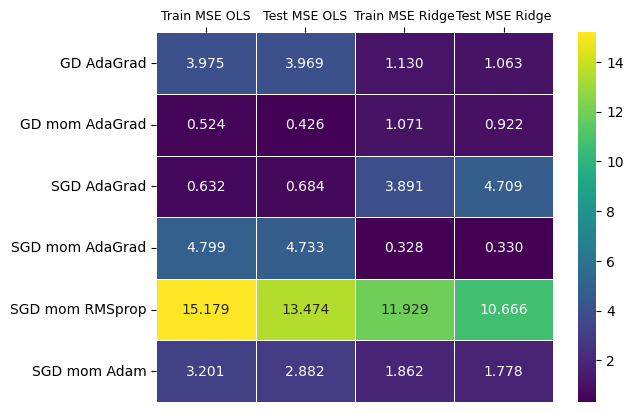

In [28]:
np.random.seed(2024)
MSE_val = np.zeros((6, 4))

# ---------------------- OLS ----------------------
# GD without momentum
model_OLS = GradientDescend(momentum=False, method="Adagrad_GD", learning_rate=optimal_gamma[0], batch_size=optimal_batch_size[0, 0])
MSE_val[0, 0], MSE_val[0, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)

# GD with momentum
model_OLS = GradientDescend(method="Adagrad_GD", learning_rate=optimal_gamma[0], delta_momentum=optimal_delta[0], batch_size=optimal_batch_size[1, 0])
MSE_val[1, 0], MSE_val[1, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)

# SGD without momentum
model_OLS = GradientDescend(momentum=False, optimizer='sgd', method="Adagrad_GD", learning_rate=optimal_gamma[0], batch_size=optimal_batch_size[2, 0])
MSE_val[2, 0], MSE_val[2, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)

# SGD with momentum
model_OLS = GradientDescend(optimizer='sgd', method="Adagrad_GD", learning_rate=optimal_gamma[0], delta_momentum=optimal_delta[0], batch_size=optimal_batch_size[3, 0])
MSE_val[3, 0], MSE_val[3, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)

# RMS with momentum
model_OLS = GradientDescend(optimizer='sgd', method="RMSprop", batch_size=optimal_batch_size[4, 0])
MSE_val[4, 0], MSE_val[4, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS)

# ADAM with momentum
model_OLS = GradientDescend(optimizer='sgd', method="ADAM", batch_size=optimal_batch_size[5, 0])
MSE_val[5, 0], MSE_val[5, 1] = train_test_error(X_train, X_test, z_train, z_test, model_OLS) 

# ---------------------- Ridge ----------------------
# GD without momentum
model_Ridge = GradientDescend(momentum=False, method="Adagrad_GD", Ridge=True, learning_rate=optimal_gamma[1], batch_size=optimal_batch_size[0, 1])
MSE_val[0, 2], MSE_val[0, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

# GD with momentum
model_Ridge = GradientDescend(method="Adagrad_GD", Ridge=True, learning_rate=optimal_gamma[1], delta_momentum=optimal_delta[1], batch_size=optimal_batch_size[1, 1])
MSE_val[1, 2], MSE_val[1, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

# SGD without momentum
model_Ridge = GradientDescend(momentum=False, optimizer='sgd', method="Adagrad_GD", Ridge=True, learning_rate=optimal_gamma[1], batch_size=optimal_batch_size[2, 1])
MSE_val[2, 2], MSE_val[2, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

# SGD with momentum
model_Ridge = GradientDescend(optimizer='sgd', method="Adagrad_GD", Ridge=True, learning_rate=optimal_gamma[1], delta_momentum=optimal_delta[1], batch_size=optimal_batch_size[3, 1])
MSE_val[3, 2], MSE_val[3, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

# RMS with momentum
model_Ridge = GradientDescend(optimizer='sgd', method="RMSprop", Ridge=True, batch_size=optimal_batch_size[4, 1])
MSE_val[4, 2], MSE_val[4, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge)

# ADAM with momentum
model_Ridge = GradientDescend(optimizer='sgd', method="ADAM", Ridge=True, batch_size=optimal_batch_size[5, 1])
MSE_val[5, 2], MSE_val[5, 3] = train_test_error(X_train, X_test, z_train, z_test, model_Ridge) 

# ---------------------- Plot the results ----------------------
index = ["GD AdaGrad", "GD mom AdaGrad", "SGD AdaGrad", "SGD mom AdaGrad", "SGD mom RMSprop", "SGD mom Adam"]
MSE_val = np.around(MSE_val, decimals=3)
df = pd.DataFrame(MSE_val, index=index, columns=["Train MSE OLS", "Test MSE OLS", "Train MSE Ridge", "Test MSE Ridge"])
fig = sns.heatmap(df, cmap="viridis", annot=True, linewidth=.5, fmt=".3f")

# Set font size for x-axis labels
fig.set_xticklabels(fig.get_xticklabels(), fontsize=9)  # Change the fontsize to your preference
fig.set_yticklabels(fig.get_yticklabels(), fontsize=10)  # Adjust y-axis labels size if needed
fig.set(xlabel="", ylabel="")
fig.xaxis.tick_top()
# plt.savefig(f"/Users/elisaottoboni/Desktop/ML/Images/Heatmap_final.pdf", format='pdf', bbox_inches='tight')